In [2]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from statsmodels.tsa.stattools import adfuller

# Directory paths
output_dir = "D:/sp2025/dataset/entropy_test/"
modulated_data_dir = "D:/sp2025/dataset/modulated_data/"

# Entropy calculation function for complex values
def complex_entropy(complex_data):
    unique, counts = np.unique(complex_data, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# PSD calculation using FFT and extraction of metrics
def calculate_psd_metrics(data):
    freqs = np.fft.fftfreq(len(data))
    psd = np.abs(fft(data)) ** 2
    spectral_flatness = np.exp(np.mean(np.log(psd + 1e-10))) / (np.mean(psd) + 1e-10)
    psd_variance = np.var(psd)
    return spectral_flatness, psd_variance

# Autocorrelation calculation and extraction of metrics
def calculate_autocorr_metrics(data, lag=100):
    autocorr = np.correlate(data - np.mean(data), data - np.mean(data), mode='full')
    autocorr = autocorr[autocorr.size // 2 : autocorr.size // 2 + lag] / np.max(autocorr)
    first_lag_corr = autocorr[1] if len(autocorr) > 1 else 0
    decay_lag = np.argmax(autocorr < 0.1) if any(autocorr < 0.1) else lag
    return first_lag_corr, decay_lag

# Stationarity test using Augmented Dickey-Fuller
def test_stationarity(data):
    result = adfuller(data)
    return result[1]  # p-value; typically, p < 0.05 indicates stationary

# Load modulated data for a given modulation scheme
def load_data(scheme):
    real_file_path = f'{modulated_data_dir}/{scheme}_real.csv'
    imag_file_path = f'{modulated_data_dir}/{scheme}_im.csv'
    real_data = pd.read_csv(real_file_path, header=None).values.flatten()
    imag_data = pd.read_csv(imag_file_path, header=None).values.flatten()
    return real_data + 1j * imag_data

# Load smorphed (hidden) data for a given modulation scheme
def load_hidden_data(scheme):
    hidden_real_file_path = f'{output_dir}/{scheme}_manyseeds_hidden_real.csv'
    hidden_imag_file_path = f'{output_dir}/{scheme}_manyseeds_hidden_imag.csv'
    hidden_real = pd.read_csv(hidden_real_file_path, header=None).values.flatten()
    hidden_imag = pd.read_csv(hidden_imag_file_path, header=None).values.flatten()
    return hidden_real + 1j * hidden_imag

# List of modulation schemes
modulation_schemes = ['bpsk', 'qpsk', '8psk', '16qam', '32qam', '64qam', '128qam', '256qam', '512qam', '1024qam']

# Initialize results list to store all metrics
results = []

# Calculate metrics for each modulation scheme
for scheme in modulation_schemes:
    scheme_results = {'Scheme': scheme}
    try:
        # Modulated data
        print(f"Processing modulated data for {scheme}...")
        modulated_data = load_data(scheme)
        modulated_data = modulated_data[:50000]  # Limit data for testing
        
        # Calculate metrics
        modulated_entropy = complex_entropy(modulated_data)
        
        # Store modulated results
        scheme_results.update({
            'Modulated Entropy': modulated_entropy
        })
        
    except FileNotFoundError:
        print(f"Original data not found for {scheme}")

    try:
        # Smorphed (hidden) data
        print(f"Processing smorphed data for {scheme}...")
        smorphed_data = load_hidden_data(scheme)
        smorphed_data = smorphed_data[:50000]  # Limit data for testing
        
        # Calculate metrics
        smorphed_entropy = complex_entropy(smorphed_data)
       
        # Store smorphed results
        scheme_results.update({
            'Smorphed Entropy': smorphed_entropy
        })
        
    except FileNotFoundError:
        print(f"Smorphed data not found for {scheme}")
    
    # Append scheme results to the main results list
    results.append(scheme_results)

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results side by side
print(results_df)


Processing modulated data for bpsk...
Processing smorphed data for bpsk...
Processing modulated data for qpsk...
Processing smorphed data for qpsk...
Processing modulated data for 8psk...
Processing smorphed data for 8psk...
Processing modulated data for 16qam...
Processing smorphed data for 16qam...
Processing modulated data for 32qam...
Processing smorphed data for 32qam...
Processing modulated data for 64qam...
Processing smorphed data for 64qam...
Processing modulated data for 128qam...
Processing smorphed data for 128qam...
Processing modulated data for 256qam...
Processing smorphed data for 256qam...
Processing modulated data for 512qam...
Processing smorphed data for 512qam...
Processing modulated data for 1024qam...
Processing smorphed data for 1024qam...
    Scheme  Modulated Entropy  Smorphed Entropy
0     bpsk           0.999996         15.064006
1     qpsk           1.999941         15.319892
2     8psk           2.999833         15.497108
3    16qam           3.999687     

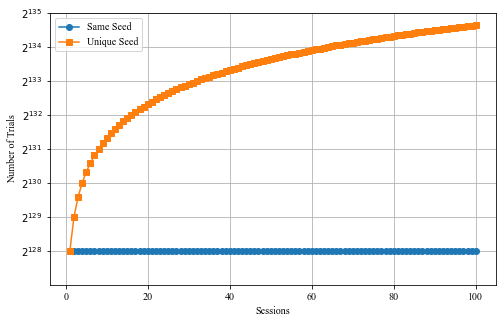

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot settings
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20

def calculate_log2_trials(security_bits, num_signals):
    log2_total_seeds = security_bits
    log2_trials_same_seed = log2_total_seeds
    log2_trials_unique_seeds = log2_total_seeds + np.log2(num_signals)
    return log2_trials_same_seed, log2_trials_unique_seeds

security_bits_list = [128]
num_signals_range = np.arange(1, 101)

for security_bits in security_bits_list:
    log2_trials_same_seed_list = []
    log2_trials_unique_seeds_list = []

    for num_signals in num_signals_range:
        log2_trials_same_seed, log2_trials_unique_seeds = calculate_log2_trials(security_bits, num_signals)
        log2_trials_same_seed_list.append(log2_trials_same_seed)
        log2_trials_unique_seeds_list.append(log2_trials_unique_seeds)

    plt.figure(figsize=(8, 5))
    plt.plot(num_signals_range, log2_trials_same_seed_list, label='Same Seed', marker='o')
    plt.plot(num_signals_range, log2_trials_unique_seeds_list, label='Unique Seed', marker='s')
    plt.xlabel('Sessions')
    plt.ylabel('Number of Trials')
    plt.ylim(127, 135)
    plt.yticks(range(128, 136), [f'$2^{{{i}}}$' for i in range(128, 136)])  # Custom tick labels
    plt.legend(loc='best', ncol=1)
    plt.grid(True)
    plt.show()


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# WiFi 802.11ax Parameters for 40 MHz Bandwidth
BW = 40e6  # 40 MHz bandwidth
FFT_size = 512  # Corresponding FFT size for 40 MHz
sampling_rate = 80e6  # 80 MHz sampling rate

# Define bandwidth options with corresponding FFT sizes and sampling rates
bandwidth_options = {
    20e6: {'FFT_size': 512, 'sampling_rate': 40e6},
    40e6: {'FFT_size': 1024, 'sampling_rate': 80e6},
    80e6: {'FFT_size': 2048, 'sampling_rate': 160e6}
}

# Define modulation schemes
# List of modulation schemes
modulation_schemes = ['bpsk', 'qpsk', '8psk', '16qam', '32qam', '64qam', '128qam', '256qam', '512qam', '1024qam']

modulated_data_dir = "D:/sp2025/dataset/modulated_data/" 
hidden_data_dir = "D:/sp2025/dataset/entropy_test/"

# Plot settings
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20  # Adjusted for subplot readability

# Load data for a given scheme
def load_data(scheme, modulated_data_dir, hidden_data_dir):
    num = 500000  # Load a fixed number of points
    real_file_path = f'{modulated_data_dir}/{scheme}_real.csv'
    imag_file_path = f'{modulated_data_dir}/{scheme}_im.csv'
    hidden_real_file_path = f'{hidden_data_dir}/{scheme}_manyseeds_hidden_real.csv'
    hidden_imag_file_path = f'{hidden_data_dir}/{scheme}_manyseeds_hidden_imag.csv'
    
    real_data = pd.read_csv(real_file_path, header=None).values.flatten()[:num]
    imag_data = pd.read_csv(imag_file_path, header=None).values.flatten()[:num]
    hidden_real_data = pd.read_csv(hidden_real_file_path, header=None).values.flatten()[:num]
    hidden_imag_data = pd.read_csv(hidden_imag_file_path, header=None).values.flatten()[:num]
    
    return real_data, imag_data, hidden_real_data, hidden_imag_data

def compute_fft(data, sampling_rate, fft_size):
    fft_data = np.fft.fft(data, n=fft_size)
    fft_freq = np.fft.fftfreq(fft_size, 1/sampling_rate)
    return fft_data, fft_freq

def estimate_bandwidth(fft_data, fft_freq):
    power_spectrum = np.abs(fft_data)**2
    power_spectrum /= np.max(power_spectrum)
    significant_freqs = fft_freq[power_spectrum > 0.009]
    return np.max(significant_freqs) - np.min(significant_freqs)

def analyze_scheme(scheme, BW, FFT_size, sampling_rate):
    real_data, imag_data, hidden_real_data, hidden_imag_data = load_data(scheme, modulated_data_dir, hidden_data_dir)
    original_signal = real_data + 1j * imag_data
    hidden_signal = hidden_real_data + 1j * hidden_imag_data
    original_fft, freq = compute_fft(original_signal, sampling_rate, FFT_size)
    hidden_fft, _ = compute_fft(hidden_signal, sampling_rate, FFT_size)
    original_bw = estimate_bandwidth(original_fft, freq)
    hidden_bw = estimate_bandwidth(hidden_fft, freq)
    return original_bw, hidden_bw

for BW, params in bandwidth_options.items():
    original_bandwidths = []
    hidden_bandwidths = []
    FFT_size = params['FFT_size']
    sampling_rate = params['sampling_rate']
    print(f"\nAnalysis for BW: {BW/1e6} MHz, FFT size: {FFT_size}, Sampling rate: {sampling_rate/1e6} MHz")
    for scheme in modulation_schemes:
        original_bw, hidden_bw = analyze_scheme(scheme, BW, FFT_size, sampling_rate)
        ratio = (hidden_bw - original_bw) / original_bw
        print(f"{scheme}: Ratio of BW Change = {ratio:.4f}")



Analysis for BW: 20.0 MHz, FFT size: 512, Sampling rate: 40.0 MHz
bpsk: Ratio of BW Change = 0.0000
qpsk: Ratio of BW Change = 0.0000
8psk: Ratio of BW Change = 0.0000
16qam: Ratio of BW Change = 0.0000
32qam: Ratio of BW Change = 0.0020
64qam: Ratio of BW Change = 0.0000
128qam: Ratio of BW Change = 0.0000
256qam: Ratio of BW Change = 0.0000
512qam: Ratio of BW Change = 0.0000
1024qam: Ratio of BW Change = 0.0000

Analysis for BW: 40.0 MHz, FFT size: 1024, Sampling rate: 80.0 MHz
bpsk: Ratio of BW Change = 0.0000
qpsk: Ratio of BW Change = 0.0010
8psk: Ratio of BW Change = 0.0000
16qam: Ratio of BW Change = 0.0000
32qam: Ratio of BW Change = 0.0000
64qam: Ratio of BW Change = 0.0000
128qam: Ratio of BW Change = 0.0000
256qam: Ratio of BW Change = 0.0000
512qam: Ratio of BW Change = 0.0000
1024qam: Ratio of BW Change = -0.0010

Analysis for BW: 80.0 MHz, FFT size: 2048, Sampling rate: 160.0 MHz
bpsk: Ratio of BW Change = 0.0000
qpsk: Ratio of BW Change = 0.0000
8psk: Ratio of BW Chang